# Finite-Difference Simulation of Lid-Driven Cavity Flow
**(Final Assignment of Computational Physics 2025)**



## To Do
1. Check Pressure again and add Boundary conditions for pressure.
2. Probably remove storage of every u, w
3. Make Center vx part of the regular code
4. Plot the fields at time [-1]


## General Infromation about Running the Code 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

libertine_installed = True # Only set this to true if the font Linux Libertine is installed

# Create data and figures folders if they do not exist
folder = "data"
if not os.path.exists(folder):
    os.mkdir(folder)

folder = "figures"
if not os.path.exists(folder):
    os.mkdir(folder)
    

## Visualization

In [9]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler(color=["black"] 
                            + plt.rcParams['axes.prop_cycle'].by_key()['color']),
    "font.family": "serif",             # Serif fonts (e.g., Times-like)
    "font.size": 14,                    # Base font size
    "mathtext.fontset": "cm",           # Math Font to match a bit better
    "legend.fontsize": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,                  # High resolution
    "savefig.dpi": 300,
    "axes.linewidth": 0.8,              # Thin axis lines
    "xtick.direction": "in",            # Ticks pointing inward
    "ytick.direction": "in",
    "xtick.top": True,                  # Ticks on all sides
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "grid.linewidth": 0.4
})

if libertine_installed: plt.rcParams.update({"font.serif": ["Linux Libertine"]})  # Same font as in LaTeX)

fsize_small = (4,2.75) # for a single colum in double colum
fsize_large = (6.5,4)

In [70]:
def plot_field(field, title, filename, fsize=fsize_small, show_contours=False, n_contours=5):
    """
    INPUT
    -----
    field:    NxN numpy array to visualize
    title:    plot title
    filename: file where the figure will be saved, preferably as .pdf
    """

    plt.figure(figsize=fsize)
    im = plt.imshow(field, origin='lower', extent=[0,1,0,1], cmap='plasma')
    plt.colorbar(im, label='value (a.u.)')
    # Contours
    if show_contours:
        cs = plt.contour(
            field,
            levels=n_contours,
            colors="black",
            linewidths=0.8,
            origin='lower',
            extent=[0,1,0,1]
        )
    # plt.clabel(cs, inline=True, fontsize=8)

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    
    file = os.path.join("figures", filename)
    plt.savefig(file)
    plt.show()
    plt.close()

## Building the Functions

In [48]:
class LDC:
    def __init__(self,h,dt,Re,grid_size, vx_top=1, vx_bottom=0):
        self.h = h
        self.dt = dt 
        self.Re = Re
        self.grid_size = grid_size
        self.vx_top = vx_top
        self.vx_bottom = vx_bottom
        self.initialize()

    # =====
    def initialize(self): # Careful, for changing grid_size you have to reassign the whole class
        self.N_y, self.N_x = self.grid_size # first y then x, so if we print it out it corresponds to the figure

    def update_stream_SOR(self, u, w, omega, max_iter, tol):
        '''
        '''
        for it in range(max_iter):
            max_r = 0.0
            for j in range(1, self.N_y-1):
                for i in range(1, self.N_x-1):
                    u_new = 0.25 * (u[j+1,i] + u[j-1,i] + u[j,i+1] + u[j,i-1] + self.h*self.h * w[j,i])
                    r = u_new - u[j,i]
                    u[j,i] += omega * r
                    max_r = max(max_r, abs(r))

            if max_r < tol: break

        return u
    
    # =====
    def vorticity_boundary(self, w, u):
        factor = 2/(self.h*self.h)
        w[-1, :] = - factor * u[-2,:] - (2/self.h) * self.vx_top    # Top wall (A)
        w[:, -1] = - factor * u[:,-2]                               # Right wall (B)
        w[0, :] = - factor * u[1, :] + (2/self.h) * self.vx_bottom  # Bottom wall (C)
        w[:, 0] = - factor * u[:, 1]                                # Left wall (D)

        return w
    
    # =====
    def update_vorticity(self,u, w):
        ''' 
        See report for equation
        '''
        w_new = np.copy(w)

        termA = (u[1:-1, 2:] - u[1:-1, :-2]) * (w[2:, 1:-1] - w[:-2, 1:-1])
        termB= (u[2:, 1:-1] - u[:-2, 1:-1]) * (w[1:-1, 2:] - w[1:-1, :-2])
        termC = w[1:-1, 2:] + w[1:-1, :-2] + w[2:, 1:-1] + w[:-2, 1:-1] - 4 * w[1:-1, 1:-1]

        w_new[1:-1, 1:-1] = (w[1:-1, 1:-1] + self.dt / (self.h * self.h) * (0.25 * (termA - termB) + (1 / self.Re) * termC))

        return w_new
    
    # =====
    def pressure_boundary(self, p, w):
        # we set p[0,0]=0 and start there clockwise (B-C-D-A) replacing p[0,0] in the end
        p[0,0] = 0.0 # Starting point
        # (D) left wall
        for j in range(self.N_y-1):
            p[j+1,0] = p[j,0] + 1/self.Re * (w[j,1] - w[j,0])
        # (A) top wall
        for i in range(self.N_x-1):
            p[-1,i+1] = p[-1,i] - 1/self.Re * (w[-1,i] - w[-2,i])
        # (B) right wall
        for j in reversed(range(self.N_y-1)):
            p[j-1,-1] = p[j,-1] - 1/self.Re * (w[j,-1] - w[j,-2])
        # (C) bottom wall
        for i in reversed(range(self.N_x-1)):
            p[0,i-1] = p[0,i] + 1/self.Re * (w[1,i] - w[0,i])

        return p

    # =====
    def update_pressure_SOR(self, p, u, omega, max_iter, tol):
        ''' 
        '''
        
        for it in range(max_iter):
            max_r = 0.0
            for j in range(1, self.N_y-1):
                for i in range(1, self.N_x-1):
                    termA = (p[j,i+1] + p[j,i-1] + p[j+1,i] + p[j-1,i])
                    termB = 2 * (u[j,i+1] + u[j,i-1] + u[j+1,i] + u[j-1,i] - 4*u[j,i]) 
                    termC = 1/(8*self.h**2) * (u[j+1,i+1] - u[j-1,i+1] - u[j+1,i-1] + u[j-1,i-1])**2
                    p_new = (0.25) * (termA - termB - termC)

                    r = p_new - p[j,i]
                    p[j,i] += omega * r
                    max_r = max(max_r, abs(r))

            if max_r < tol: break

        return p

    # =====
    def test_stability(self):
        stability = self.dt/(self.Re*self.h*self.h)
        if stability > 0.25:
            print(f'Warning: Stability condition not met! value: {stability:.3f}')
        else:
            print(f'Stability criterion value: {stability:.3f}')

        return None
    
    # =====       
    def get_vx_center(self, u):
        i = int(self.N_x/2)
        j = int(self.N_y/2)
        return (u[j,i+1] - u[j,i-1])/(2*self.h) 
    
    # =====
    def system_evolution(self, 
                    n_t,
                    get_pressure=True,
                    SOR_omega=1.7,  
                    SOR_max_iter=10000, 
                    SOR_tol=1e-5,
                    ):
        '''
        '''
        self.test_stability()

        # Initialize storage arrays and arrays at t=0
        u_history = np.zeros((n_t, self.N_y, self.N_x)) # u at t=0 is 0
        w_history = np.zeros((n_t, self.N_y, self.N_x))
        w_history[0,-1, :] = -2 * self.vx_top / self.h  # Top wall vorticity at t=0 (u=0 everywhere)
        w_history[0,0, :] = 2 * self.vx_bottom / self.h  # Bottom wall vorticity at t=0 
        vxc_history = np.zeros(n_t)
                                                                        
        u = u_history[0]
        w = w_history[0]

        p = np.zeros((self.N_y, self.N_x))  # Initialize pressure array

        for n in tqdm(range(1,n_t)):
            # Update stream function
            u = self.update_stream_SOR(u, w, omega=SOR_omega, max_iter=SOR_max_iter, tol=SOR_tol)
            w = self.vorticity_boundary(w, u)
            w = self.update_vorticity(u, w)
            
            vxc_history[n] = self.get_vx_center(u)
            u_history[n] = u
            w_history[n] = w
            if get_pressure:
                p = self.pressure_boundary(p, w)
                p = self.update_pressure_SOR(p, u, omega=SOR_omega, max_iter=SOR_max_iter, tol=SOR_tol)

        if get_pressure:
            return u_history, w_history, p, vxc_history
        else:
            return u_history, w_history, vxc_history
    # =====
    def convert_to_velocity(self, u):
        v_x = np.zeros((self.N_y, self.N_x))
        v_y = np.zeros((self.N_y, self.N_x))

        for j in range(1, self.N_y-1):
            for i in range(1, self.N_x-1):
                v_x[j,i] = (u[j,i+1] - u[j,i-1])/(2*self.h)
                v_y[j,i] = -(u[j+1,i] - u[j-1,i])/(2*self.h)
        
        # Apply boundary conditions for velocity
        v_x[-1, :] = self.vx_wall # Top wall, rest is already correctly 0

        return v_x, v_y
        


Let's test the function for a small grid size and a low number of time steps:

Stability criterion value: 0.050


100%|██████████| 99/99 [00:04<00:00, 21.71it/s]


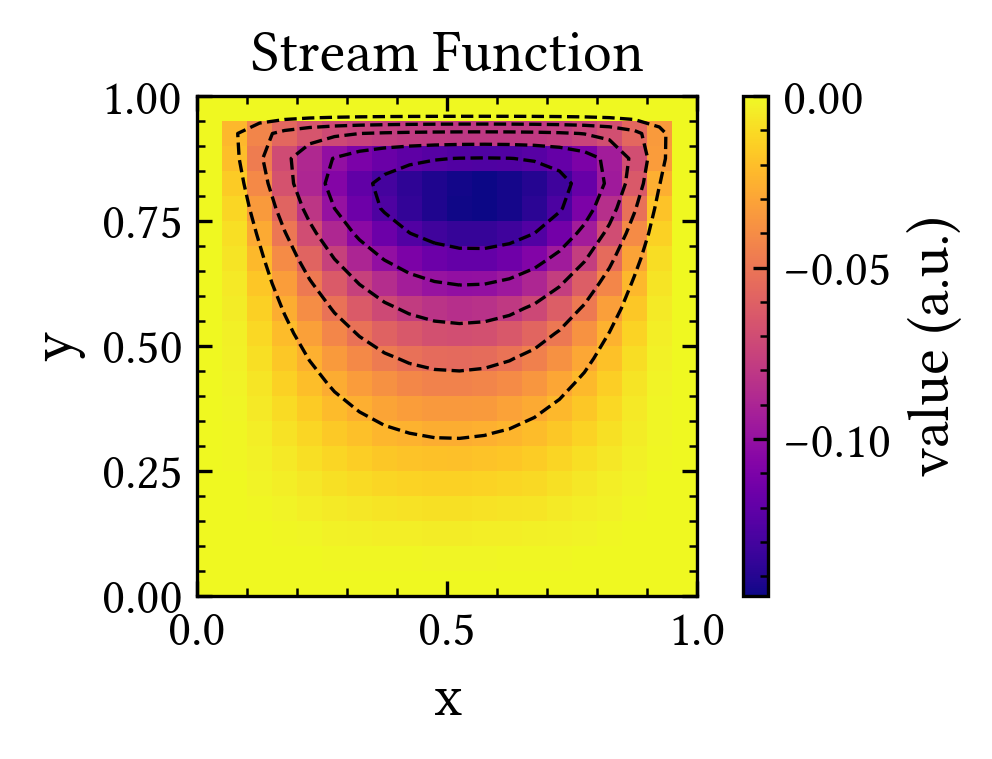

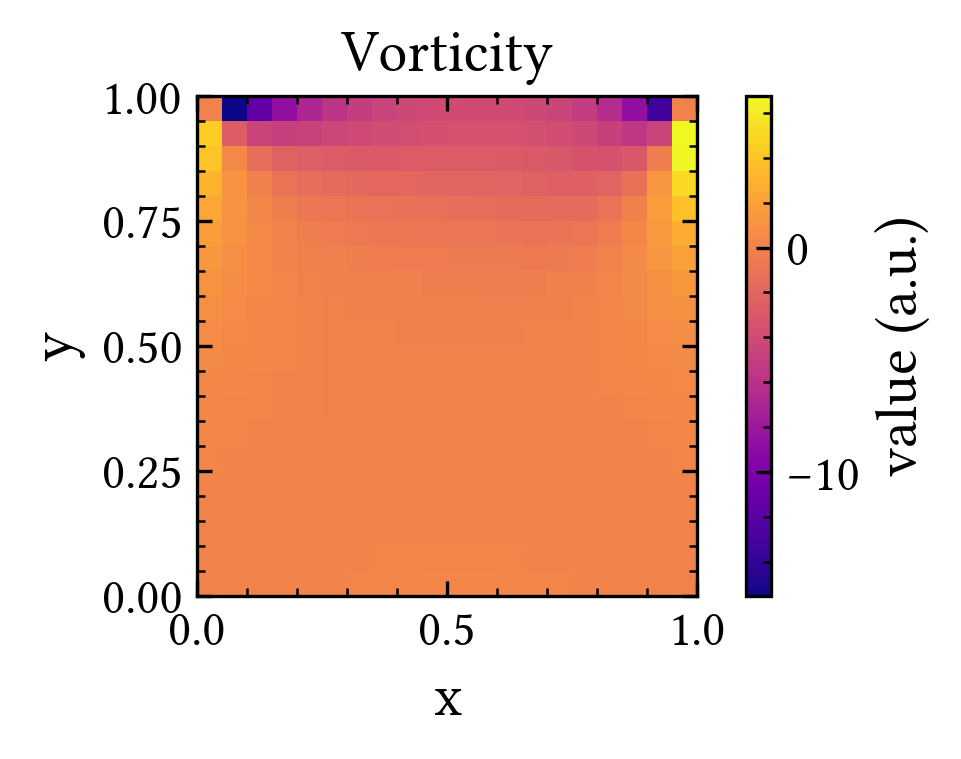

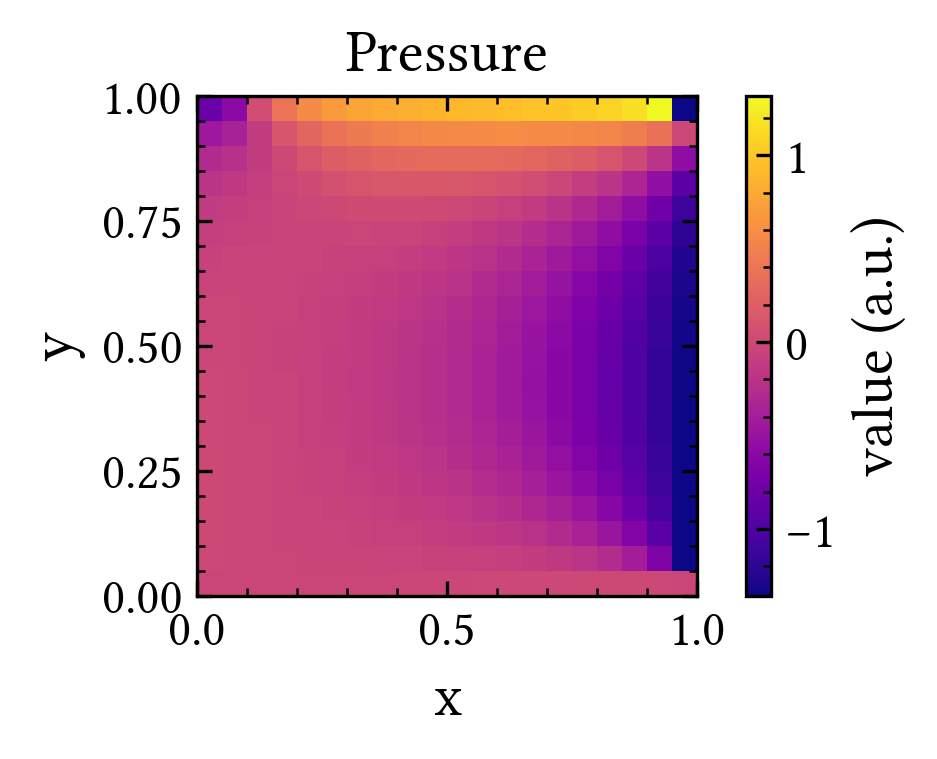

In [71]:
ldc_test = LDC(h=0.1, dt=0.01, Re=20, grid_size=(20,20))
u_test, w_test, p, _ = ldc_test.system_evolution(n_t=100,get_pressure=True)

# u_test, w_test = system_evolution(h=0.1, dt=0.01, n_t=100, Re=20, grid_size=(20,20),vx_wall=1)


plot_field(u_test[-1], title="Stream Function", filename="stream_function_test.pdf", show_contours=True)
plot_field(w_test[-1], title="Vorticity", filename="vorticity_test.pdf")
plot_field(p, title="Pressure", filename="pressure_test.pdf")    


In [54]:
n_t = 1000

print("Re=10")
ldc_10 = LDC(h=0.1,
             dt = 0.01,
             Re = 10,
             grid_size=(20,20),
             )

u_10, w_10, vxc_10 = ldc_10.system_evolution(n_t=n_t, get_pressure=False)
np.save('data/ldc_Re10.npy', (u_10, w_10))

print("Re=100")
ldc_100 = LDC(h=0.1,
             dt = 0.01,
             Re = 100,
             grid_size=(20,20),
             )

u_100, w_100, vxc_100 = ldc_100.system_evolution(n_t=n_t, get_pressure=False)
np.save('data/ldc_Re100.npy', (u_100, w_100))

print("Re=200")
ldc_200 = LDC(h=0.1,
             dt = 0.01,
             Re = 200,
             grid_size=(20,20),
             )

u_200, w_200, vxc_200 = ldc_200.system_evolution(n_t=n_t, get_pressure=False)
np.save('data/ldc_Re200.npy', (u_200, w_200))

Re=10
Stability criterion value: 0.100


100%|██████████| 999/999 [00:01<00:00, 515.77it/s] 


Re=100
Stability criterion value: 0.010


100%|██████████| 999/999 [00:03<00:00, 291.81it/s]


Re=200
Stability criterion value: 0.005


100%|██████████| 999/999 [00:03<00:00, 327.32it/s]


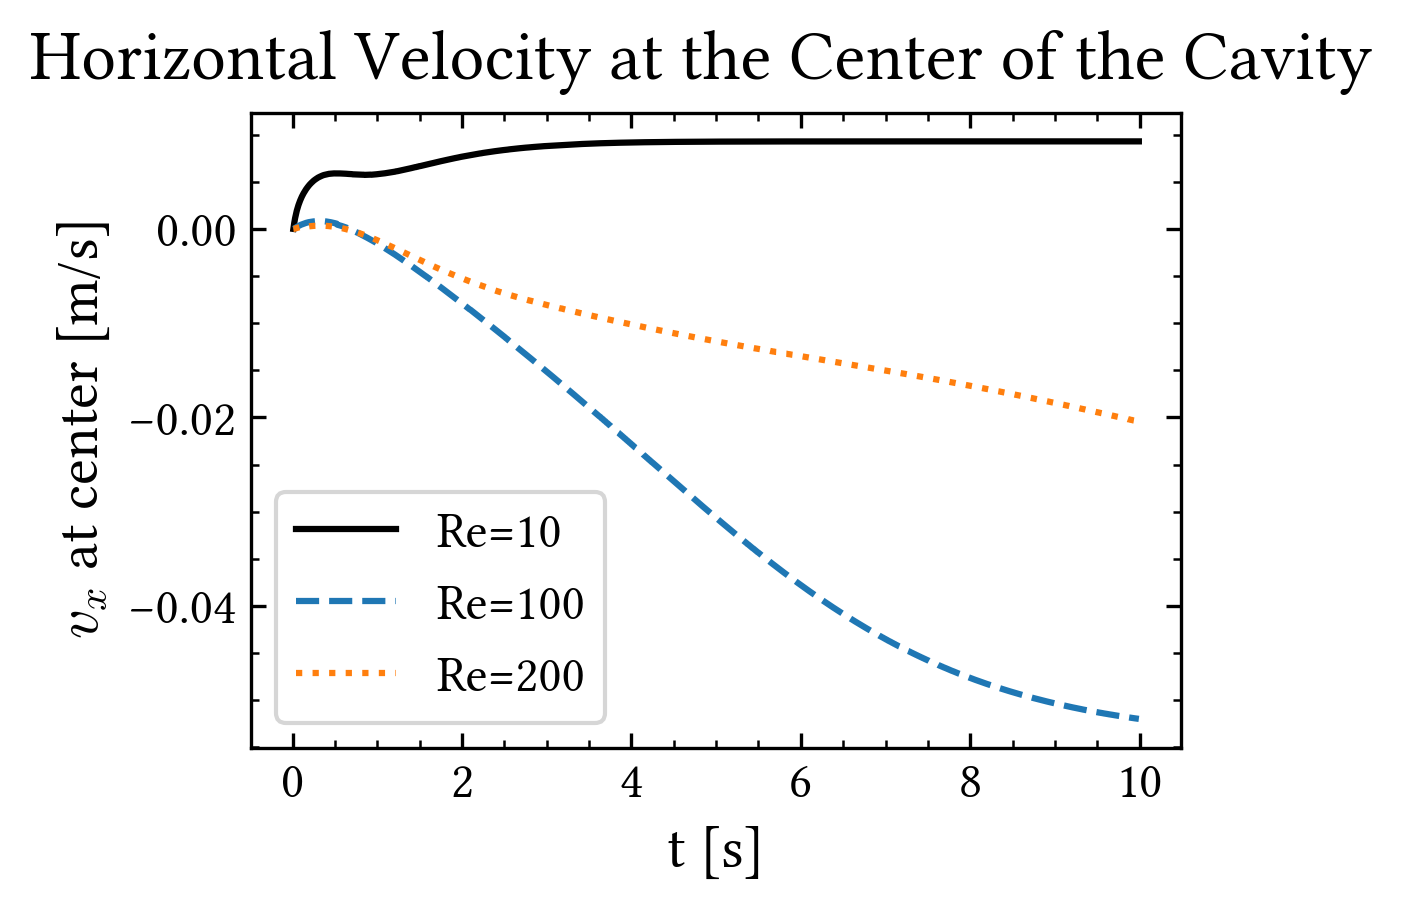

In [55]:
# plt.imshow(u_10[-1], origin='lower'); plt.title("Stream function")
# plt.colorbar()
# plt.figure()
# plt.imshow(w_10[-1], origin='lower'); plt.title("Vorticity")
# plt.colorbar()


t = np.arange(0,n_t)*ldc_10.dt

fig, ax = plt.subplots(figsize=fsize_small)
fig.suptitle("Horizontal Velocity at the Center of the Cavity")

ax.plot(t[1:], vxc_10[1:], label='Re=10')
ax.plot(t[1:], vxc_100[1:], label='Re=100', linestyle='--')
ax.plot(t[1:], vxc_200[1:], label='Re=200', linestyle=':')

ax.set_xlabel(r"t [s]")
ax.set_ylabel(r"$v_x$ at center [m/s]")
ax.legend()

plt.savefig('figures/vx_center.pdf')
plt.show()

# Dump

Old `update_vorticity` that uses python loop calculations instead of more efficient numpy arrays:

In [ ]:

# def update_vorticity(self,u, w):

#     w_new = np.copy(w)

#     for j in range(1, self.N_y-1):
#         for i in range(1, self.N_x-1):
#             term1a = (u[j,i+1] - u[j,i-1]) * (w[j+1,i] - w[j-1,i]) 
#             term1b = (u[j+1,i] - u[j-1,i]) * (w[j,i+1] - w[j,i-1])
#             term2 = w[j,i+1] + w[j,i-1] + w[j+1,i] + w[j-1,i] - 4*w[j,i]

#             w_new[j,i] = w[j,i] + self.dt/(self.h*self.h) * (0.25 * (term1a - term1b) + (1/self.Re) * (term2))
    
#     return w_new 